## Run the below import cell first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

## Run the cell below to get the data loaded and mostly ready

In [2]:
# condensing several of the above cells into this one
# One

conn = sqlite3.connect('stockPrediction.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM price_history l INNER JOIN stock r ON r.stock_id = l.stock_id;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

# columns = pd.MultiIndex.from_product([[i for i in symbols], ['open_price', 'high_price', 'low_price', 'close_price']], names=['symbol', 'type'])

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# Two

# remove stocks w/ less than 1000 data points
s = df.groupby(level=0).size()
# s = s.where(s > 1000).dropna()
s = s.where(s > 1550).dropna()  # playing around w/ different values here to get a model that can actually be trained
dfs = s.to_frame()
dfs = dfs.reset_index()
df = df.reset_index()
# dfs

# Three
df = pd.merge(df, dfs, how='inner', left_on='stock_symbol', right_on='stock_symbol', left_index=True)
df = df.drop_duplicates()
# this line below added in on 5/14 22:37:
df = df.drop(columns=[0])

# Four

# df = df.drop_duplicates(subset=['price_datetime'])
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])
df

open_price                                          \
stock_symbol              AAIC       AAU    ABEO   ABEV    ABIO   ABML   
price_datetime                                                           
2021-02-11 09:30:00      3.690  0.963900  3.4550  2.820  5.2885  3.720   
2021-02-11 09:45:00      3.710  0.918901  3.3796  2.855  5.4800  3.690   
2021-02-11 10:00:00      3.740  0.936800  3.3070  2.830  5.4200  3.670   
2021-02-11 10:15:00      3.740  0.939900  3.2886  2.835  5.3500  3.620   
2021-02-11 10:30:00      3.730  0.947001  3.3300  2.830  5.3900  3.610   
...                        ...       ...     ...    ...     ...    ...   
2021-05-10 14:45:00      4.065  0.542500  1.3801  3.215  3.1080  1.630   
2021-05-10 15:00:00      4.055  0.540000  1.3900  3.200  3.1000  1.595   
2021-05-10 15:15:00      4.060  0.540041  1.3850  3.200  3.1100  1.575   
2021-05-10 15:30:00      4.045  0.540900  1.3850  3.210  3.0950  1.590   
2021-05-10 15:45:00      4.045  0.540900  1.3850  3.215  3.0850  1.580   

                                                      ... stock_splits      \
stock_symbol           ABUS    ACRX     ACST    ACTG  ...          CEI DSS   
price_datetime                                        ...                    
2021-02-11 09:30:00  4.4100  2.6300  1.17000  8.2400  ...          NaN   0   
2021-02-11 09:45:00  4.4213  2.5486  1.15010  7.8500  ...          NaN   0   
2021-02-11 10:00:00  4.5393  2.5400  1.12890  7.9000  ...          NaN   0   
2021-02-11 10:15:00  4.5900  2.5750  1.11500  7.8401  ...          NaN   0   
2021-02-11 10:30:00  4.5200  2.6014  1.14000  7.8200  ...          NaN   0   
...                     ...     ...      ...     ...  ...          ...  ..   
2021-05-10 14:45:00  2.6650  1.1100  0.44690  5.6950  ...            0   0   
2021-05-10 15:00:00  2.6700  1.1100  0.44770  5.6500  ...            0   0   
2021-05-10 15:15:00  2.6900  1.1100  0.44400  5.6600  ...            0   0   
2021-05-10 15:30:00  2.6700  1.1100  0.43651  5.6000  ...            0   0   
2021-05-10 15:45:00  2.6550  1.1150  0.44910  5.6000  ...            0   0   

                                                            
stock_symbol        FCEL HIMX HTBX IMGN INO PACB PLUG VERI  
price_datetime                                              
2021-02-11 09:30:00    0    0    0    0   0    0    0    0  
2021-02-11 09:45:00    0    0    0    0   0    0    0    0  
2021-02-11 10:00:00    0    0    0    0   0    0    0    0  
2021-02-11 10:15:00    0    0    0    0   0    0    0    0  
2021-02-11 10:30:00    0    0    0    0   0    0    0    0  
...                  ...  ...  ...  ...  ..  ...  ...  ...  
2021-05-10 14:45:00    0    0    0    0   0    0    0    0  
2021-05-10 15:00:00    0    0    0    0   0    0    0    0  
2021-05-10 15:15:00    0    0    0    0   0    0    0    0  
2021-05-10 15:30:00    0    0    0    0   0    0    0    0  
2021-05-10 15:45:00    0    0    0    0   0    0    0    0  

[1588 rows x 833 columns]

In [3]:
# attempting once again to impute
columns = df.close_price.columns
df = df.reset_index()
imputer = KNNImputer(n_neighbors=10, weights='uniform')
imputed_data = imputer.fit_transform(df[['close_price']])
clean_data = pd.DataFrame(imputed_data, columns=columns)
# clean_data['price_datetime'] = df['price_datetime']
# df = pd.merge(df, clean_data, on='price_datetime')
clean_data

stock_symbol    AAIC       AAU    ABEO    ABEV    ABIO    ABML    ABUS  \
0             3.7270  0.920000  3.3700  2.8600  5.4354  3.6865  4.4300   
1             3.7400  0.936200  3.3043  2.8350  5.4300  3.6600  4.5400   
2             3.7400  0.932201  3.2800  2.8400  5.3500  3.6100  4.6000   
3             3.7390  0.948600  3.3281  2.8311  5.3700  3.6200  4.5292   
4             3.7250  0.999800  3.3106  2.8300  5.4111  3.6145  4.5150   
...              ...       ...     ...     ...     ...     ...     ...   
1583          4.0525  0.540000  1.3850  3.2050  3.0910  1.6000  2.6700   
1584          4.0600  0.540799  1.3850  3.2000  3.1000  1.5700  2.6900   
1585          4.0450  0.540800  1.3842  3.2098  3.1000  1.5900  2.6642   
1586          4.0450  0.540900  1.3900  3.2150  3.0900  1.5700  2.6550   
1587          4.0600  0.540000  1.3400  3.2000  3.0600  1.5800  2.6500   

stock_symbol    ACRX    ACST  ACTG  ...       CEI     DSS       FCEL     HIMX  \
0             2.5401  1.1600  7.85  ...  1.850370  4.0500  26.930000  15.3000   
1             2.5464  1.1211  7.90  ...  1.850370  4.0250  26.889999  15.2000   
2             2.5700  1.1100  7.84  ...  1.850370  4.0863  26.930000  14.9200   
3             2.6050  1.1500  7.83  ...  1.850370  4.0600  26.860001  15.2399   
4             2.6350  1.1150  7.80  ...  1.852330  4.2300  26.870001  15.1850   
...              ...     ...   ...  ...       ...     ...        ...      ...   
1583          1.1102  0.4472  5.64  ...  0.664300  2.8000   7.320000  12.2200   
1584          1.1100  0.4441  5.68  ...  0.645100  2.8100   7.327400  12.3000   
1585          1.1100  0.4366  5.59  ...  0.654799  2.8011   7.290000  12.3370   
1586          1.1200  0.4490  5.60  ...  0.648300  2.8050   7.275000  12.4100   
1587          1.1200  0.4475  5.53  ...  0.642000  2.8000   7.240000  12.3000   

stock_symbol     HTBX   IMGN      INO       PACB       PLUG       VERI  
0             11.4449  8.040  13.1919  53.064999  65.099998  48.529999  
1             11.6300  8.085  13.0778  52.499901  65.159897  47.700001  
2             11.6740  8.020  12.9800  52.700001  64.983498  47.759998  
3             11.6601  8.080  13.1500  52.395000  65.000000  48.040001  
4             11.9600  8.130  13.0813  51.939999  65.040001  48.259998  
...               ...    ...      ...        ...        ...        ...  
1583           6.2500  6.670   6.7346  23.135000  20.508801  18.940001  
1584           6.2950  6.625   6.7300  23.270000  20.480000  19.004999  
1585           6.2750  6.600   6.7200  23.250000  20.320000  19.059999  
1586           6.3000  6.610   6.7300  23.139999  20.285000  18.900000  
1587           6.3000  6.510   6.6900  23.040001  20.070000  18.840000  

[1588 rows x 119 columns]

In [4]:
df['close_price'] = clean_data
df = df.set_index('price_datetime')

## Test-train split below
Uses close prices only. Will try a future version that uses all available data.

In [5]:
# first cell for test-train split
data = df['close_price']
data = data.reset_index()

# I am doing this differently. I am using 80% as training data, 20% as test
data_size = len(data)
training_data = data.iloc[:(int(data_size * .8))]
test_data = data.iloc[(int(data_size * .8)):]

In [9]:
data

stock_symbol       price_datetime    AAIC       AAU    ABEO    ABEV    ABIO  \
0             2021-02-11 09:30:00  3.7270  0.920000  3.3700  2.8600  5.4354   
1             2021-02-11 09:45:00  3.7400  0.936200  3.3043  2.8350  5.4300   
2             2021-02-11 10:00:00  3.7400  0.932201  3.2800  2.8400  5.3500   
3             2021-02-11 10:15:00  3.7390  0.948600  3.3281  2.8311  5.3700   
4             2021-02-11 10:30:00  3.7250  0.999800  3.3106  2.8300  5.4111   
...                           ...     ...       ...     ...     ...     ...   
1583          2021-05-10 14:45:00  4.0525  0.540000  1.3850  3.2050  3.0910   
1584          2021-05-10 15:00:00  4.0600  0.540799  1.3850  3.2000  3.1000   
1585          2021-05-10 15:15:00  4.0450  0.540800  1.3842  3.2098  3.1000   
1586          2021-05-10 15:30:00  4.0450  0.540900  1.3900  3.2150  3.0900   
1587          2021-05-10 15:45:00  4.0600  0.540000  1.3400  3.2000  3.0600   

stock_symbol    ABML    ABUS    ACRX    ACST  ...       CEI     DSS  \
0             3.6865  4.4300  2.5401  1.1600  ...  1.850370  4.0500   
1             3.6600  4.5400  2.5464  1.1211  ...  1.850370  4.0250   
2             3.6100  4.6000  2.5700  1.1100  ...  1.850370  4.0863   
3             3.6200  4.5292  2.6050  1.1500  ...  1.850370  4.0600   
4             3.6145  4.5150  2.6350  1.1150  ...  1.852330  4.2300   
...              ...     ...     ...     ...  ...       ...     ...   
1583          1.6000  2.6700  1.1102  0.4472  ...  0.664300  2.8000   
1584          1.5700  2.6900  1.1100  0.4441  ...  0.645100  2.8100   
1585          1.5900  2.6642  1.1100  0.4366  ...  0.654799  2.8011   
1586          1.5700  2.6550  1.1200  0.4490  ...  0.648300  2.8050   
1587          1.5800  2.6500  1.1200  0.4475  ...  0.642000  2.8000   

stock_symbol       FCEL     HIMX     HTBX   IMGN      INO       PACB  \
0             26.930000  15.3000  11.4449  8.040  13.1919  53.064999   
1             26.889999  15.2000  11.6300  8.085  13.0778  52.499901   
2             26.930000  14.9200  11.6740  8.020  12.9800  52.700001   
3             26.860001  15.2399  11.6601  8.080  13.1500  52.395000   
4             26.870001  15.1850  11.9600  8.130  13.0813  51.939999   
...                 ...      ...      ...    ...      ...        ...   
1583           7.320000  12.2200   6.2500  6.670   6.7346  23.135000   
1584           7.327400  12.3000   6.2950  6.625   6.7300  23.270000   
1585           7.290000  12.3370   6.2750  6.600   6.7200  23.250000   
1586           7.275000  12.4100   6.3000  6.610   6.7300  23.139999   
1587           7.240000  12.3000   6.3000  6.510   6.6900  23.040001   

stock_symbol       PLUG       VERI  
0             65.099998  48.529999  
1             65.159897  47.700001  
2             64.983498  47.759998  
3             65.000000  48.040001  
4             65.040001  48.259998  
...                 ...        ...  
1583          20.508801  18.940001  
1584          20.480000  19.004999  
1585          20.320000  19.059999  
1586          20.285000  18.900000  
1587          20.070000  18.840000  

[1588 rows x 120 columns]

In [6]:
# second cell for test-train split
# adding the price_datetime index back
training_data = training_data.set_index('price_datetime')
test_data = test_data.set_index('price_datetime')

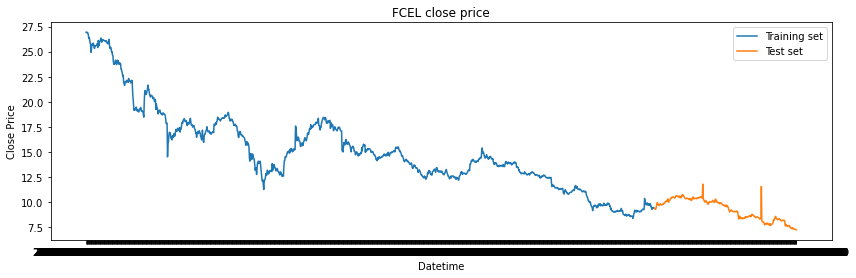

In [7]:
# testing the sets w/ matplotlib
plt.figure(figsize=(14,4))
plt.plot(training_data['FCEL'])
plt.plot(test_data['FCEL'])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title("FCEL close price")
plt.show()

## Data Normalization
This method uses the MinMaxScaler, but a log return can sometimes be more useful. 

In [7]:
# drop security you'd like to predict w/ these lines
# first, it creates a new dataframe w/ only the security you'd like to predict
training_data_predicted = training_data['FCEL']
training_data_predicted = training_data_predicted.to_frame()
training_data_predicted

FCEL
price_datetime                
2021-02-11 09:30:00  26.930000
2021-02-11 09:45:00  26.889999
2021-02-11 10:00:00  26.930000
2021-02-11 10:15:00  26.860001
2021-02-11 10:30:00  26.870001
...                        ...
2021-04-22 13:45:00   9.288300
2021-04-22 14:00:00   9.395400
2021-04-22 14:15:00   9.469100
2021-04-22 14:30:00   9.467700
2021-04-22 14:45:00   9.410000

[1270 rows x 1 columns]

In [22]:
training_data.shape, training_data_predicted.shape

((1270, 118), (1270, 1))

In [8]:
# I have altered this so it works better w/ my data.
minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

training_data = training_data.drop(columns='FCEL')

# no idea if the line below will work the way I need it to or not
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append('FCEL')

train_scaled = pd.DataFrame(train_scaled, columns=columns)
train_scaled

AAIC       AAU      ABEO      ABEV      ABIO      ABML      ABUS  \
0     0.102667  0.851893  0.922018  0.833364  0.997900  0.898661  0.892857   
1     0.120000  0.881960  0.891881  0.787076  0.995434  0.889813  0.958333   
2     0.120000  0.874538  0.880734  0.796334  0.958904  0.873118  0.994047   
3     0.118667  0.904974  0.902798  0.779856  0.968036  0.876457  0.951905   
4     0.100000  1.000000  0.894771  0.777819  0.986804  0.874620  0.943452   
...        ...       ...       ...       ...       ...       ...       ...   
1265  0.460000  0.208797  0.144495  0.962970  0.086758  0.171926  0.142857   
1266  0.453333  0.200260  0.146789  0.962970  0.105023  0.173261  0.157738   
1267  0.453333  0.198589  0.149083  0.981485  0.109589  0.191960  0.172619   
1268  0.493333  0.172977  0.145229  1.000000  0.123288  0.196968  0.184524   
1269  0.480000  0.172791  0.145688  0.990742  0.118721  0.201977  0.184524   

          ACRX      ACST      ACTG  ...       CEI       DSS      HIMX  \
0     0.936944  1.000000  0.671718  ...  0.558804  0.660737  0.794348   
1     0.941130  0.949177  0.685597  ...  0.558804  0.648030  0.778650   
2     0.956811  0.934675  0.668943  ...  0.558804  0.679187  0.734694   
3     0.980066  0.986935  0.666167  ...  0.558804  0.665819  0.784914   
4     1.000000  0.941207  0.657840  ...  0.559726  0.752224  0.776295   
...        ...       ...       ...  ...       ...       ...       ...   
1265  0.039867  0.085707  0.091598  ...  0.020092  0.071156  0.403469   
1266  0.049834  0.085446  0.102701  ...  0.024845  0.088945  0.416798   
1267  0.057807  0.087928  0.105476  ...  0.022868  0.086404  0.428163   
1268  0.059801  0.090802  0.111028  ...  0.023668  0.096569  0.434851   
1269  0.053156  0.086099  0.111028  ...  0.022774  0.091131  0.425432   

          HTBX      IMGN       INO      PACB      PLUG      VERI      FCEL  
0     0.880727  0.274339  0.663783  1.000000  0.998522  0.978969  1.000000  
1     0.911813  0.287001  0.648785  0.979865  1.000000  0.949877  0.997842  
2     0.919203  0.268711  0.635929  0.986995  0.995649  0.951980  1.000000  
3     0.916868  0.285594  0.658276  0.976127  0.996056  0.961795  0.996224  
4     0.967234  0.299662  0.649245  0.959915  0.997043  0.969506  0.996764  
...        ...       ...       ...       ...       ...       ...       ...  
1265  0.077136  0.198368  0.118137  0.191359  0.045141  0.212758  0.048452  
1266  0.078816  0.191334  0.116467  0.197772  0.049457  0.213635  0.054229  
1267  0.078816  0.198368  0.124578  0.201335  0.052047  0.211707  0.058204  
1268  0.092251  0.203995  0.131808  0.206680  0.053774  0.212408  0.058128  
1269  0.090572  0.196961  0.131150  0.202761  0.051061  0.201016  0.055016  

[1270 rows x 119 columns]

In [30]:
# validate min/max values
train_scaled.describe()

AAIC          AAU         ABEO         ABEV         ABIO  \
count  1270.000000  1270.000000  1270.000000  1270.000000  1270.000000   
mean      0.530813     0.336095     0.321305     0.617586     0.369298   
std       0.169266     0.248379     0.192903     0.186562     0.240408   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.446666     0.145733     0.184450     0.518608     0.164384   
50%       0.506667     0.271345     0.325688     0.629698     0.365297   
75%       0.586667     0.515729     0.435780     0.740789     0.505822   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              ABML         ABUS         ACRX         ACST         ACTG  ...  \
count  1270.000000  1270.000000  1270.000000  1270.000000  1270.000000  ...   
mean      0.357854     0.396819     0.428614     0.363131     0.330821  ...   
std       0.249996     0.254568     0.233420     0.227469     0.221655  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.170256     0.199955     0.279900     0.210521     0.166549  ...   
50%       0.286954     0.315476     0.410299     0.349686     0.267855  ...   
75%       0.509166     0.538690     0.578073     0.445486     0.463541  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

               CEI          DSS         HIMX         HTBX         IMGN  \
count  1270.000000  1270.000000  1270.000000  1270.000000  1270.000000   
mean      0.278105     0.453537     0.487185     0.314880     0.399049   
std       0.198942     0.236832     0.203247     0.203649     0.203630   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.159926     0.278208     0.317111     0.174673     0.255346   
50%       0.238942     0.447268     0.466656     0.302239     0.415025   
75%       0.368001     0.642312     0.623450     0.409613     0.524761   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               INO         PACB         PLUG         VERI         FCEL  
count  1270.000000  1270.000000  1270.000000  1270.000000  1270.000000  
mean      0.281025     0.329874     0.380649     0.356529     0.364416  
std       0.232293     0.190063     0.250780     0.236695     0.217730  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.111597     0.208913     0.198323     0.144497     0.232807  
50%       0.192736     0.293133     0.326715     0.270782     0.328479  
75%       0.330794     0.356594     0.551031     0.544252     0.487252  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 119 columns]

## Shaping data for LSTM

In [9]:
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# check shape (again) before start training
'''shape_chk = []
for i in train_scaled.close_price.columns:
    index = {}
    index["X_train"] = X_train.shape
    index["y_train"] = y_train.shape
    shape_chk.append(index)
pd.DataFrame(shape_chk)'''

'shape_chk = []\nfor i in train_scaled.close_price.columns:\n    index = {}\n    index["X_train"] = X_train.shape\n    index["y_train"] = y_train.shape\n    shape_chk.append(index)\npd.DataFrame(shape_chk)'

In [22]:
X_train.shape, y_train.shape

((1210, 60, 119), (1210,))

## Build the LSTM network

In [10]:
%time

# LSTM architecture
regressor = tf.keras.Sequential()

# Layer 1, w/ dropout regularisation
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 2
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 3
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.6))

# Layer 4
regressor.add(tf.keras.layers.LSTM(units=20))
regressor.add(tf.keras.layers.Dropout(0.6))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# fit to training set
for i in training_data.columns:
    print("Fitting to", i)
    regressor.fit(X_train, y_train, epochs=10, batch_size=32)

poch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 8/10
38/38 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 9/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 10/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0022
Fitting to BRQS
Epoch 1/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 2/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 4/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 5/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 8/10
38/38 [======

In [11]:
regressor.save('model_05172021')

INFO:tensorflow:Assets written to: model_05172021\assets
INFO:tensorflow:Assets written to: model_05172021\assets


In [10]:
regressor = tf.keras.models.load_model('model_05172021')

## Predicting future values using the Test set
To predict future prices, need to do a couple of data processing tasks
1. Merge training and test datasets on 0 axis.
2. set the n_lags as time steps
3. transform the new dataset
4. reshape the dataset

In [32]:
inputs

stock_symbol           AAIC       AAU    ABEO    ABEV   ABIO  ABML    ABUS  \
price_datetime                                                               
2021-04-20 13:00:00  3.9100  0.468500  1.4208  2.8500  3.340  1.00  3.0200   
2021-04-20 13:15:00  3.9000  0.465000  1.4200  2.8350  3.360  1.01  3.0100   
2021-04-20 13:30:00  3.9100  0.462700  1.4200  2.8450  3.350  1.03  3.0000   
2021-04-20 13:45:00  3.9200  0.462600  1.4200  2.8550  3.330  1.03  3.0050   
2021-04-20 14:00:00  3.9400  0.462000  1.4200  2.8400  3.320  1.03  3.0100   
...                     ...       ...     ...     ...    ...   ...     ...   
2021-05-10 14:45:00  4.0525  0.540000  1.3850  3.2050  3.091  1.60  2.6700   
2021-05-10 15:00:00  4.0600  0.540799  1.3850  3.2000  3.100  1.57  2.6900   
2021-05-10 15:15:00  4.0450  0.540800  1.3842  3.2098  3.100  1.59  2.6642   
2021-05-10 15:30:00  4.0450  0.540900  1.3900  3.2150  3.090  1.57  2.6550   
2021-05-10 15:45:00  4.0600  0.540000  1.3400  3.2000  3.060  1.58  2.6500   

stock_symbol           ACRX    ACST  ACTG  ...   CDXC       CEI     DSS  \
price_datetime                             ...                            
2021-04-20 13:00:00  1.1600  0.4216  5.48  ...  7.430  0.681500  2.8050   
2021-04-20 13:15:00  1.1600  0.4225  5.50  ...  7.370  0.680000  2.7964   
2021-04-20 13:30:00  1.1600  0.4214  5.49  ...  7.360  0.678850  2.7905   
2021-04-20 13:45:00  1.1600  0.4214  5.51  ...  7.430  0.680300  2.7900   
2021-04-20 14:00:00  1.1600  0.4191  5.51  ...  7.410  0.684400  2.7710   
...                     ...     ...   ...  ...    ...       ...     ...   
2021-05-10 14:45:00  1.1102  0.4472  5.64  ...  7.150  0.664300  2.8000   
2021-05-10 15:00:00  1.1100  0.4441  5.68  ...  7.260  0.645100  2.8100   
2021-05-10 15:15:00  1.1100  0.4366  5.59  ...  7.240  0.654799  2.8011   
2021-05-10 15:30:00  1.1200  0.4490  5.60  ...  7.235  0.648300  2.8050   
2021-05-10 15:45:00  1.1200  0.4475  5.53  ...  7.150  0.642000  2.8000   

stock_symbol           HIMX    HTBX   IMGN     INO       PACB       PLUG  \
price_datetime                                                             
2021-04-20 13:00:00  11.890  6.3500  7.305  8.7150  28.580000  25.470100   
2021-04-20 13:15:00  11.840  6.3200  7.260  8.6550  28.520000  25.572701   
2021-04-20 13:30:00  11.840  6.2733  7.260  8.6200  28.510000  25.660000   
2021-04-20 13:45:00  11.920  6.3300  7.285  8.6600  28.790100  25.879999   
2021-04-20 14:00:00  11.870  6.3000  7.290  8.6600  28.928200  25.629999   
...                     ...     ...    ...     ...        ...        ...   
2021-05-10 14:45:00  12.220  6.2500  6.670  6.7346  23.135000  20.508801   
2021-05-10 15:00:00  12.300  6.2950  6.625  6.7300  23.270000  20.480000   
2021-05-10 15:15:00  12.337  6.2750  6.600  6.7200  23.250000  20.320000   
2021-05-10 15:30:00  12.410  6.3000  6.610  6.7300  23.139999  20.285000   
2021-05-10 15:45:00  12.300  6.3000  6.510  6.6900  23.040001  20.070000   

stock_symbol              VERI  
price_datetime                  
2021-04-20 13:00:00  23.915001  
2021-04-20 13:15:00  23.945000  
2021-04-20 13:30:00  23.740000  
2021-04-20 13:45:00  23.834999  
2021-04-20 14:00:00  24.150000  
...                        ...  
2021-05-10 14:45:00  18.940001  
2021-05-10 15:00:00  19.004999  
2021-05-10 15:15:00  19.059999  
2021-05-10 15:30:00  18.900000  
2021-05-10 15:45:00  18.840000  

[378 rows x 118 columns]

In [27]:
predicted_input

FCEL
price_datetime             
2021-04-20 13:00:00  8.7300
2021-04-20 13:15:00  8.7200
2021-04-20 13:30:00  8.7300
2021-04-20 13:45:00  8.7885
2021-04-20 14:00:00  8.6910
...                     ...
2021-05-10 14:45:00  7.3200
2021-05-10 15:00:00  7.3274
2021-05-10 15:15:00  7.2900
2021-05-10 15:30:00  7.2750
2021-05-10 15:45:00  7.2400

[378 rows x 1 columns]

In [31]:
minmax.transform(inputs)

ValueError: operands could not be broadcast together with shapes (378,118) (119,) (378,118) 

In [11]:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs['FCEL'].to_frame()
inputs = inputs.drop(columns='FCEL')

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

Shape of test data: (378, 119)


Now, inverse the transformed data to get back the prices in a normal readable format.

In [13]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: 'FCEL_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

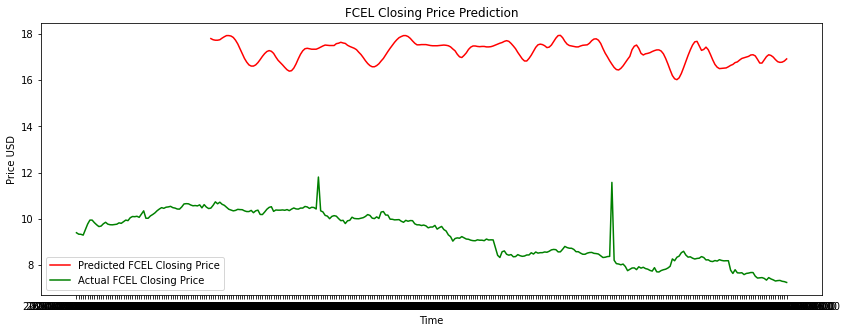

In [19]:
# Visualization
from sklearn.metrics import mean_squared_error
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(predicted_price['FCEL_predicted'], color = 'red', label= 'Predicted FCEL Closing Price')
plt.plot(test_data['FCEL'], color = 'green', label = 'Actual FCEL Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title('FCEL Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()